In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

import warnings
warnings.filterwarnings('ignore')



print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.11.0


#### **Data Loading**

In [23]:
base_dir = "Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

In [24]:
if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [25]:
WORK_DIR = work_dir

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

#### **Data Augmentation**

In [26]:
ZOOM = [0.9, 1.1]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=7000, shuffle=True)

Found 6400 images belonging to 4 classes.


In [27]:
def show_images(generator,y_pred=None):
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(12):
            ax = plt.subplot(4, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(12):
            ax = plt.subplot(4, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

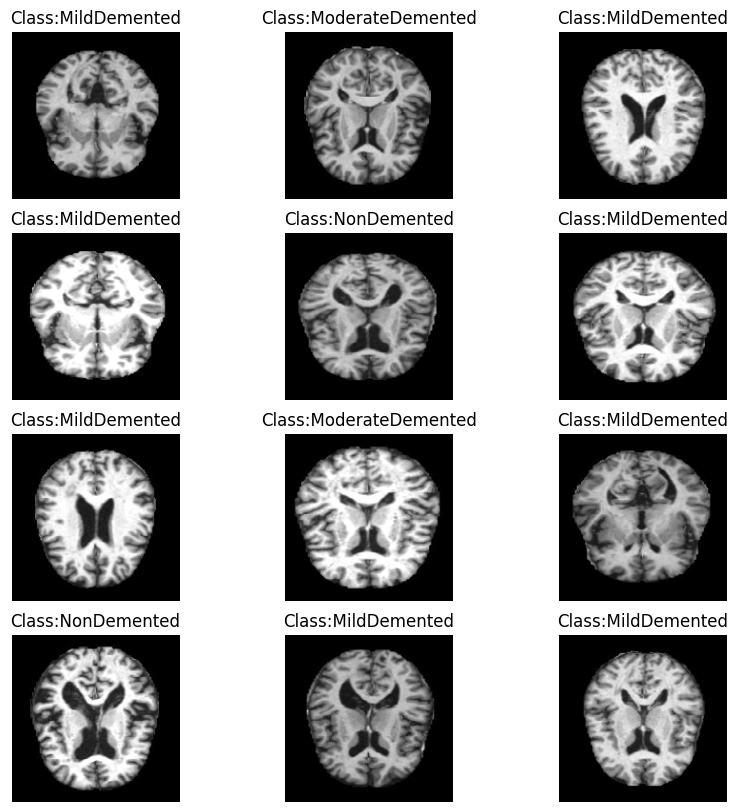

In [28]:
# Display Train Images
show_images(train_data_gen)

In [29]:
#Retrieving the data from the ImageDataGenerator iterator

train_data_x, train_labels_y = train_data_gen.next()

In [30]:
print(train_data_x.shape, train_labels_y.shape)

(6400, 176, 176, 3) (6400, 4)


In [31]:
def plot_dist(train_data, train_labels):
    labels =dict(zip([0,1,2,3], CLASSES))

    dict_images = {c:0 for c in CLASSES}
    
    for i in range(0,train_data.shape[0]):
        dict_images[labels[np.argmax(train_labels[i])]] += 1
    
    print(dict_images)
        
    sorted_dict_images = sorted(dict_images.items(), key=lambda x: x[1], reverse=True)
    classes, counts = zip(*sorted_dict_images)

    colors = np.linspace(0.2, 0.8, len(classes))

    plt.bar(range(len(classes)), counts, color=plt.cm.Reds(colors), width=0.5)

    for i, (class_label, count) in enumerate(sorted_dict_images):
        plt.text(i, count+50, count, ha='center')

    plt.xticks(range(len(classes)), classes)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Classes')

    plt.show()

{'NonDemented': 896, 'VeryMildDemented': 64, 'MildDemented': 3200, 'ModerateDemented': 2240}


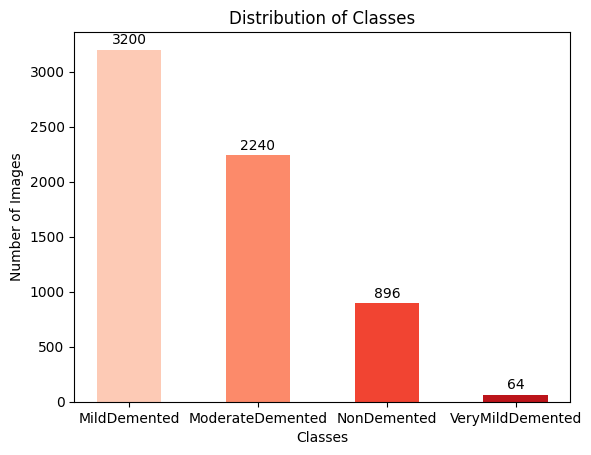

In [32]:
plot_dist(train_data_x, train_labels_y)

In [33]:
sm = SMOTE(random_state=42)

train_data_x, train_labels_y = sm.fit_resample(train_data_x.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels_y)

train_data_x = train_data_x.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data_x.shape, train_labels_y.shape)

(12800, 176, 176, 3) (12800, 4)


{'NonDemented': 3200, 'VeryMildDemented': 3200, 'MildDemented': 3200, 'ModerateDemented': 3200}


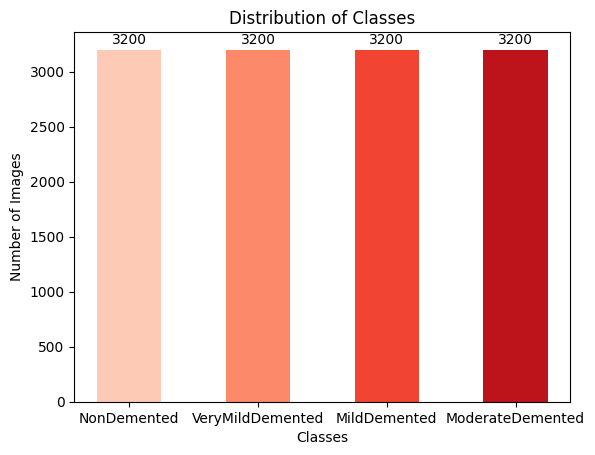

In [34]:
plot_dist(train_data_x, train_labels_y)

In [35]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data_x, train_labels_y, test_size = 0.22, random_state=42)

In [36]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.22, random_state=42)

In [64]:
print(f'Training Size : {train_data.shape} | Training Labels : {train_labels.shape}')
print(f'Validation Size : {val_data.shape} | Validation Labels : {val_labels.shape}')
print(f'Testing Size : {test_data.shape}   |  Testing Labels : {test_labels.shape}')

Training Size : (7787, 176, 176, 3) | Training Labels : (7787, 4)
Validation Size : (2197, 176, 176, 3) | Validation Labels : (2197, 4)
Testing Size : (2816, 176, 176, 3)   |  Testing Labels : (2816, 4)


#### **Constructing Model**

In [65]:
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [66]:
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [67]:
def construct_model(act='relu'):
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        
        conv_block(32),
        
        conv_block(64),
        Dropout(0.2),
        
        conv_block(128),
        Dropout(0.2),
        
        conv_block(256),
        Dropout(0.2),
        
        Flatten(),
        
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        Dense(4, activation='softmax') 
        
    ], 
        name = "cnn_model")

    return model

In [71]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

In [72]:
model = construct_model()

CALLBACKS = [my_callback]

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 176, 176, 16)      448       
                                                                 
 conv2d_56 (Conv2D)          (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 88, 88, 16)       0         
 g2D)                                                            
                                                                 
 sequential_28 (Sequential)  (None, 44, 44, 32)        14016     
                                                                 
 sequential_29 (Sequential)  (None, 22, 22, 64)        55680     
                                                                 
 dropout_21 (Dropout)        (None, 22, 22, 64)        0         
                                                         

In [60]:
"""np.savez("Variables.npz", 
         X_train=train_data, X_test=test_data, 
         Y_train=train_labels, Y_test=test_labels, 
         X_val=val_data, Y_val=val_labels)"""

'np.savez("Variables.npz", \n         X_train=train_data, X_test=test_data, \n         Y_train=train_labels, Y_test=test_labels, \n         X_val=val_data, Y_val=val_labels)'